## Predicting total energies and enthalpies of formation of metal-nonmetal compounds by linear regression 

Here, we want to study the accuracy and time used to predict variable dataset sizes using the featurizations and algorithms used in [Deml et al paper](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.93.085142)

Referred to `matminer_examples/notebooks/machine-learning/predicting-formation-enthalpy-from-composition.ipynb `

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mdf_forge.forge import Forge

from matminer.data_retrieval.retrieve_MDF import MDFDataRetrieval
from matminer.utils.conversions import str_to_composition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf

from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_predict, KFold
from sklearn import metrics

from matplotlib.colors import LogNorm

### Load Training Set 

Importing OQMD data (fully ordered ionic compounds with cations from groups 1-14 and anions from groups 15-17)

In [2]:
mdf = MDFDataRetrieval(anonymous=True)

In [3]:
oqmd_version = mdf.forge.get_dataset_version('oqmd')
print ('Current version of OQMD:', oqmd_version)

Current version of OQMD: 9


Run a faster version of demo

In [4]:
quick_demo = False

Query that gets only the converged static calculations from the OQMD.

In [5]:
query_string = 'mdf.source_name:oqmd_v{0} AND (oqmd_v{0}.configuration:static OR'\
    'oqmd_v{0}.configuration:standard) AND dft.converged:True'.format(oqmd_version)
if quick_demo:
    query_string += " AND mdf.scroll_id:<10000"

In [6]:
orig_data = mdf.get_data(query_string, unwind_arrays=False)

100%|██████████| 119440/119440 [03:26<00:00, 581.39it/s]


In [7]:
print ("Shape of data:", orig_data.shape)
orig_data.head(2)

Shape of data: (119440, 29)


,crystal_structure.cross_reference.icsd,crystal_structure.number_of_atoms,crystal_structure.space_group_number,crystal_structure.volume,dft.converged,dft.cutoff_energy,dft.exchange_correlation_functional,files,material.composition,material.elements,...,oqmd_v9.delta_e.units,oqmd_v9.delta_e.value,oqmd_v9.magnetic_moment.units,oqmd_v9.magnetic_moment.value,oqmd_v9.stability.units,oqmd_v9.stability.value,oqmd_v9.total_energy.units,oqmd_v9.total_energy.value,oqmd_v9.volume_pa.units,oqmd_v9.volume_pa.value
0,NaN,2,221,34.8770,True,520.0,PBE,"[{'data_type': 'ASCII text, with very long lin...",Ga1S1,"[Ga, S]",...,eV/atom,-0.139932,bohr/atom,NaN,eV/atom,0.649058,eV/atom,-3.575297,angstrom^3/atom,17.4385
1,NaN,3,216,81.0009,True,520.0,PBE,"[{'data_type': 'ASCII text, with very long lin...",Bi1Ge1Sc1,"[Sc, Bi, Ge]",...,eV/atom,-0.094662,bohr/atom,0.00054,eV/atom,0.458256,eV/atom,-5.091659,angstrom^3/atom,27.0003


We only need two columns: `total_energy` and `material.composition`.

In [8]:
data = orig_data[['oqmd_v{}.total_energy.value'.format(oqmd_version), 'material.composition']]

In [9]:
data = data.rename(columns={'oqmd_v{}.total_energy.value'.format(oqmd_version): 'total_energy', 'material.composition':'composition'})

### Compile Training Set 

Get only the lower-energy entry for each composition.

In [10]:
data['composition_obj'] = str_to_composition(data['composition'])

Remove compounds without `total_energy` measurement.

In [11]:
data = data.dropna(subset=['total_energy']).reset_index(drop=True)

Get only the groundstate and each composition

In [12]:
%%time
original_count = len(data)
data['mdf.composition'] = data['composition_obj'].apply(lambda x: x.reduced_formula)
data.drop_duplicates('mdf.composition', keep='first', inplace=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

/Users/AikRui/anaconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:409: UserWarning:

No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:409: UserWarning:

No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:409: UserWarning:

No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.



Removed 44840/119440 entries
CPU times: user 8.98 s, sys: 103 ms, total: 9.08 s
Wall time: 9.25 s


Remove outliers

In [13]:
original_count = len(data)
data = data[np.logical_and(data['total_energy'] >= -20, data['total_energy'] <= 5)].reset_index(drop=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 11/74600 entries


Remove elements which are not used to develop model in the paper

In [14]:
%%time
el = ['H', 'Li', 'B', 'C', 'He', 'Ne', 'Ar', 
      'Br', 'Kr', 'I', 'Xe', 'Po', 'At', 'Rn', 'Tl', 
      'Cs', 'Tc', 'Ru', 'Rh', 'Pd', 'Ta', 'W', 'Re', 
      'Os', 'Ir', 'Pt', 'Pu', 'Ac', 'Np', 'U', 'Th', 
      'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd',
      'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Pa', 
      'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 
      'Lr',
      'Be', 'Pb', 'Mo']

original_count = len(data)
for i in range(data['composition'].shape[0]):
    if any (word in data['composition'][i] for word in el):
        data = data.drop([i, i]) # drop a row by index
data = data.reset_index(drop=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 67627/74589 entries
CPU times: user 11min 27s, sys: 1min 23s, total: 12min 51s
Wall time: 15min 14s


In [15]:
print ("Final shape of data:", data.shape)

Final shape of data: (6962, 4)


**Note**: Size of our data is larger than the one used in the paper.

## Build an ML model

### Part 1: Compute Representation 

Convert our raw materials data into the required input for an ML model: a finite list of quantitative attributes. In this case, we use the attributes as shown in [Deml et al 2016](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.93.085142).

In [16]:
%%time
ft = MultipleFeaturizer([cf.ElementProperty.from_preset('deml'), 
#                          cf.CationProperty.from_preset('deml'),
#                          cf.OxidationStates.from_preset('deml'),
                         cf.TMetalFraction(),
#                          cf.ElectronegativityDiff(),
                         cf.ValenceOrbital()])
data = ft.featurize_dataframe(data, col_id='composition_obj')

CPU times: user 4.82 s, sys: 466 ms, total: 5.29 s
Wall time: 19.4 s


In [17]:
print ("Shape of featurized data: ", data.shape)
data.head(1)

Shape of featurized data:  (6962, 93)


,total_energy,composition,composition_obj,mdf.composition,minimum atom_num,maximum atom_num,range atom_num,mean atom_num,std_dev atom_num,minimum atom_mass,...,std_dev FERE correction,transition metal fraction,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons
0,-3.575297,Ga1S1,"(Ga, S)",GaS,16,31,15,23.5,10.606602,32.065,...,0.424264,0.0,2.0,2.5,5.0,0.0,0.210526,0.263158,0.526316,0.0


### Part 2: Linear Model: Stepwise Linear Regression 

Shuffling data

In [18]:
data = shuffle(data)

Each dataset is randomly divided into three groups: 
- 70% for training the model
- 15% for preliminary assessment (validation) of model's predictive ability
- 15% for independent assessment (testing) of model's predictive ability

In [19]:
x = data.drop(['total_energy', 'composition', 'composition_obj', 'mdf.composition'], 1)
y = data['total_energy']

In [20]:
n = data.shape[0]
x_train, x_val, x_test = x[:int(n*0.7)], x[int(n*0.7):int(n*0.85)], x[int(n*0.85):]
y_train, y_val, y_test = y[:int(n*0.7)], y[int(n*0.7):int(n*0.85)], y[int(n*0.85):]

Linear regression model is used. 

In [21]:
model = LinearRegression()

### Part 3: Quantifying performance of model with different number of candidate descriptors used

Implementation of stepwise linear regression where terms (candidate descriptors) from a linear model are sequentially added or removed according to their effective significance probabilities. In the paper, this approach was implemented in [JMP](https://www.jmp.com/en_us/software/predictive-analytics-software.html). Here, we use recursive feature elimination to assign weights to features and remove features with low weightage.




10-fold cross validation was used within the training set to quantify performance of model

In [22]:
kfold = KFold(10, shuffle=True)

Number of terms (candidate descriptors) to be used

In [23]:
num_features = range(10, data.shape[1], 10)

Initializing mean absolute error, mean squared error and R2 score

In [24]:
score_train = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_val = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_test = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}

Training the linear regression model with variable number of features used and quantifying the performance. 

In [25]:
for i in num_features:
    selector = RFE(model, n_features_to_select=i, step=0.9)
    selector = selector.fit(x_train, y_train)
    cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
    cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
    cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)
    for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
        score_train[scorer].append(getattr(metrics,scorer)(y_train, cv_train))
        score_val[scorer].append(getattr(metrics,scorer)(y_val, cv_val))
        score_test[scorer].append(getattr(metrics,scorer)(y_test, cv_test))

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



Plot the model performance when number of terms (candidate descriptors) is changed.

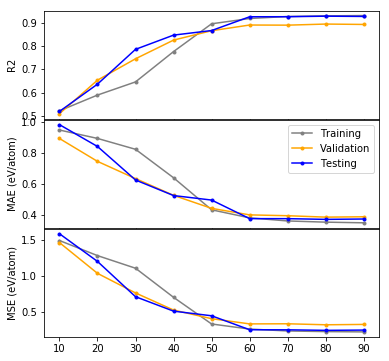

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.set_ylabel("R2")
ax2.set_ylabel("MAE (eV/atom)")
ax3.set_ylabel("MSE (eV/atom)")

ax1.plot(num_features, score_train['r2_score'], c='grey', marker='.', label='Training')
ax1.plot(num_features, score_val['r2_score'], c='orange', marker='.', label='Validation')
ax1.plot(num_features, score_test['r2_score'], c='blue', marker='.', label='Testing')

ax2.plot(num_features, score_train['mean_absolute_error'], c='grey', marker='.', label='Training')
ax2.plot(num_features, score_val['mean_absolute_error'], c='orange', marker='.', label='Validation')
ax2.plot(num_features, score_test['mean_absolute_error'], c='blue', marker='.', label='Testing')

ax3.plot(num_features, score_train['mean_squared_error'], c='grey', marker='.', label='Training')
ax3.plot(num_features, score_val['mean_squared_error'], c='orange', marker='.', label='Validation')
ax3.plot(num_features, score_test['mean_squared_error'], c='blue', marker='.', label='Testing')

ax2.legend()

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.01)

_Finding_: Around 60 terms is sufficient. 

In [27]:
selector = RFE(model, n_features_to_select=60, step=0.9)
selector = selector.fit(x_train, y_train)

In [28]:
cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)

Plot the predictions

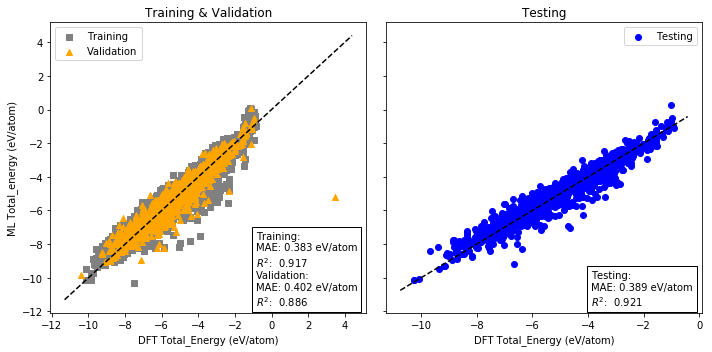

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

# Training and Validation plot
mae_train = metrics.mean_absolute_error(y_train, cv_train)
r2_train = metrics.r2_score(y_train, cv_train)
mae_val = metrics.mean_absolute_error(y_val, cv_val)
r2_val = metrics.r2_score(y_val, cv_val)
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax1.scatter(y_train, cv_train, c='grey', marker='s', label='Training')
ax1.scatter(y_val, cv_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax1.legend()

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT Total_Energy (eV/atom)')
ax1.set_ylabel('ML Total_energy (eV/atom)')

# Testing plot
mae_test = metrics.mean_absolute_error(y_test, cv_test)
r2_test = metrics.r2_score(y_test, cv_test)
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.scatter(y_test, cv_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')

ax2.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT Total_Energy (eV/atom)')

fig.set_size_inches(10, 5)
fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig('oqmd_cv.png', dpi=320)

### Prediction of formation enthalpy

Using total energy value to compute formation energy according to the equation 
$$\Delta H_f = E_{tot} - \Sigma_i c_i \mu_i^{FERE}$$